In [8]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [9]:
datasets = {
            'rna': '../data/kipan/RNASeq.csv',
            'cnv': '../data/kipan/CNV.csv',
            'rppa': '../data/kipan/RPPA.csv',
}
        
labels = '../data/kipan/Clinical.csv'

In [10]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (745, 20190)
cnv (745, 24776)
rppa (745, 166)


# Preprocessing

## Removing low-variance + null features

In [11]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    return X_new

In [12]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality])
    print(modality, new_data[modality].shape)

rna (745, 19042)
cnv (745, 5173)
rppa (745, 91)


In [13]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (745, 19042)
cnv (745, 5173)
rppa (745, 75)


In [14]:
subtypes['histological_type'].value_counts()

kidneyclearcellrenalcarcinoma        469
kidneypapillaryrenalcellcarcinoma    213
kidneychromophobe                     63
Name: histological_type, dtype: int64

In [15]:
y = LabelEncoder().fit_transform(subtypes['histological_type'])

# Testing Datasets

In [30]:
def recall_multiclass(y_test, y_pred, label):
    return recall_score(y_test, y_pred, average=None)[label]

In [38]:
from imblearn.pipeline import make_pipeline

In [16]:
'''estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, n_jobs=-1))),
    ("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", MLPClassifier(random_state=0)),
    ("svm", make_pipeline(StandardScaler(), SVC(random_state=0)))
]'''
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    #("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [17]:
pd.Series(y).value_counts()

1    469
2    213
0     63
dtype: int64

In [21]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

 25%|██▌       | 1/4 [00:57<02:53, 57.68s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.966 +/- 0.016   0.965 +/- 0.033  0.967 +/- 0.016  0.954 +/- 0.092   

            recall (KIRC)    recall (KIRP)  
logistic  0.964 +/- 0.022  0.977 +/- 0.015  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.950 +/- 0.015   0.957 +/- 0.027  0.951 +/- 0.015   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.969 +/- 0.062  0.945 +/- 0.021  0.958 +/- 0.023  


 75%|███████▌  | 3/4 [02:02<00:40, 40.77s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.950 +/- 0.018   0.951 +/- 0.030  0.951 +/- 0.018  0.954 +/- 0.062   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.951 +/- 0.025  0.948 +/- 0.041  


100%|██████████| 4/4 [02:15<00:00, 33.76s/it]


svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.968 +/- 0.018   0.965 +/- 0.033  0.968 +/- 0.018  0.954 +/- 0.092   

       recall (KIRC)    recall (KIRP)  
svc  0.966 +/- 0.025  0.977 +/- 0.015  


  0%|          | 0/4 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 1/4 [00:59<02:59, 59.75s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.863 +/- 0.021   0.796 +/- 0.041  0.861 +/- 0.022  0.669 +/- 0.118   

            recall (KIRC)    recall (KIRP)  
logistic  0.919 +/- 0.026  0.799 +/- 0.078  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.867 +/- 0.025   0.865 +/- 0.045  0.872 +/- 0.023   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.859 +/- 0.112  0.868 +/- 0.027  0.869 +/- 0.031  


 75%|███████▌  | 3/4 [01:39<00:30, 30.97s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.856 +/- 0.028   0.806 +/- 0.066  0.855 +/- 0.029  0.715 +/- 0.169   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.900 +/- 0.041  0.803 +/- 0.081  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.796 +/- 0.048   0.746 +/- 0.054  0.798 +/- 0.046  0.655 +/- 0.128   

       recall (KIRC)    recall (KIRP)  
svc  0.840 +/- 0.069  0.742 +/- 0.031  


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.742 +/- 0.005   0.568 +/- 0.018  0.731 +/- 0.010  0.223 +/- 0.036   

            recall (KIRC)    recall (KIRP)  
logistic  0.874 +/- 0.018  0.605 +/- 0.041  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.882 +/- 0.038   0.891 +/- 0.031  0.888 +/- 0.033   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.921 +/- 0.072  0.880 +/- 0.045  0.873 +/- 0.047  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.915 +/- 0.027   0.833 +/- 0.045  0.913 +/- 0.029  0.653 +/- 0.072   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.966 +/- 0.013  0.882 +/- 0.071  
svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.631 +/- 0.047   0.578 +/- 0.044  0.646 +/- 0.044  0.492 +/- 0.114   

       recall (KIRC)    recall (KIRP)  
svc  0.682 +/- 0.058  0.559 +/- 0.060  


In [22]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.015,0.957 +/- 0.027,0.951 +/- 0.015,0.969 +/- 0.062,0.945 +/- 0.021,0.958 +/- 0.023
deep_nn,0.950 +/- 0.018,0.951 +/- 0.030,0.951 +/- 0.018,0.954 +/- 0.062,0.951 +/- 0.025,0.948 +/- 0.041
svc,0.968 +/- 0.018,0.965 +/- 0.033,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.796 +/- 0.041,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
balanced_random_forest,0.867 +/- 0.025,0.865 +/- 0.045,0.872 +/- 0.023,0.859 +/- 0.112,0.868 +/- 0.027,0.869 +/- 0.031
deep_nn,0.856 +/- 0.028,0.806 +/- 0.066,0.855 +/- 0.029,0.715 +/- 0.169,0.900 +/- 0.041,0.803 +/- 0.081
svc,0.796 +/- 0.048,0.746 +/- 0.054,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.568 +/- 0.018,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
balanced_random_forest,0.882 +/- 0.038,0.891 +/- 0.031,0.888 +/- 0.033,0.921 +/- 0.072,0.880 +/- 0.045,0.873 +/- 0.047
deep_nn,0.915 +/- 0.027,0.833 +/- 0.045,0.913 +/- 0.029,0.653 +/- 0.072,0.966 +/- 0.013,0.882 +/- 0.071
svc,0.631 +/- 0.047,0.578 +/- 0.044,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060


(None, None, None)

In [77]:
def plot_scores(estimator_names, scorers, metrics=["f1", "accuracy"]):
    score_lists = {}
    for metric in metrics:
        score_lists[metric] = [score["test_" + metric] for score in scorers]

    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        sns.boxplot(data=_list, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, showfliers=False).set_xticklabels(estimator_names, rotation=45)
        plt.title(title)

In [23]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc"
]

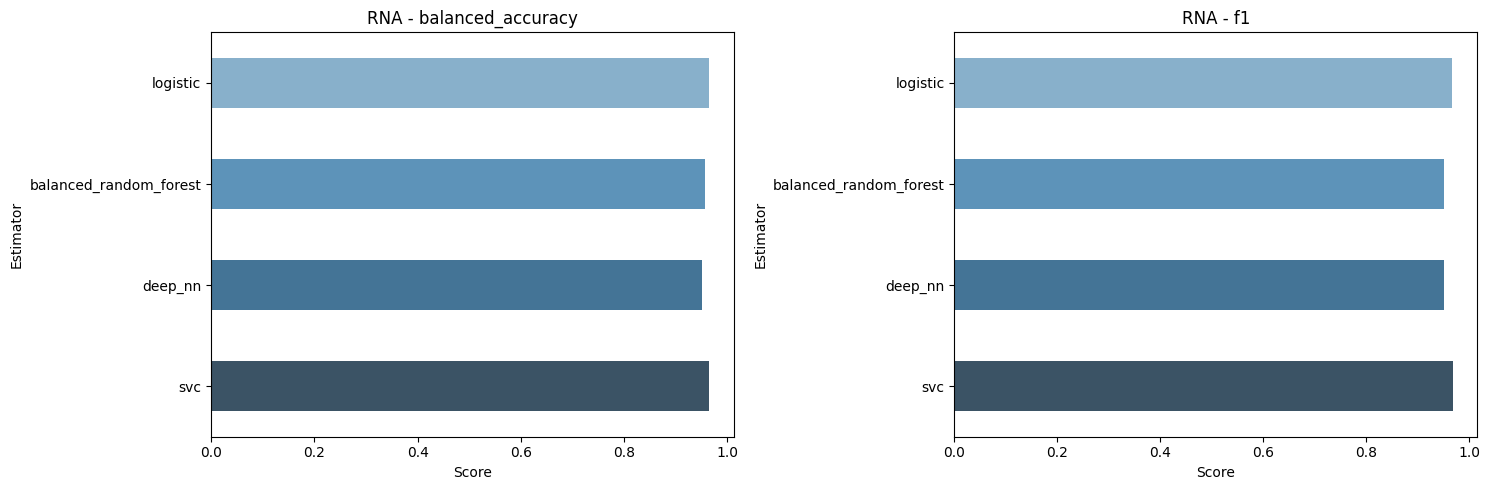

In [24]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

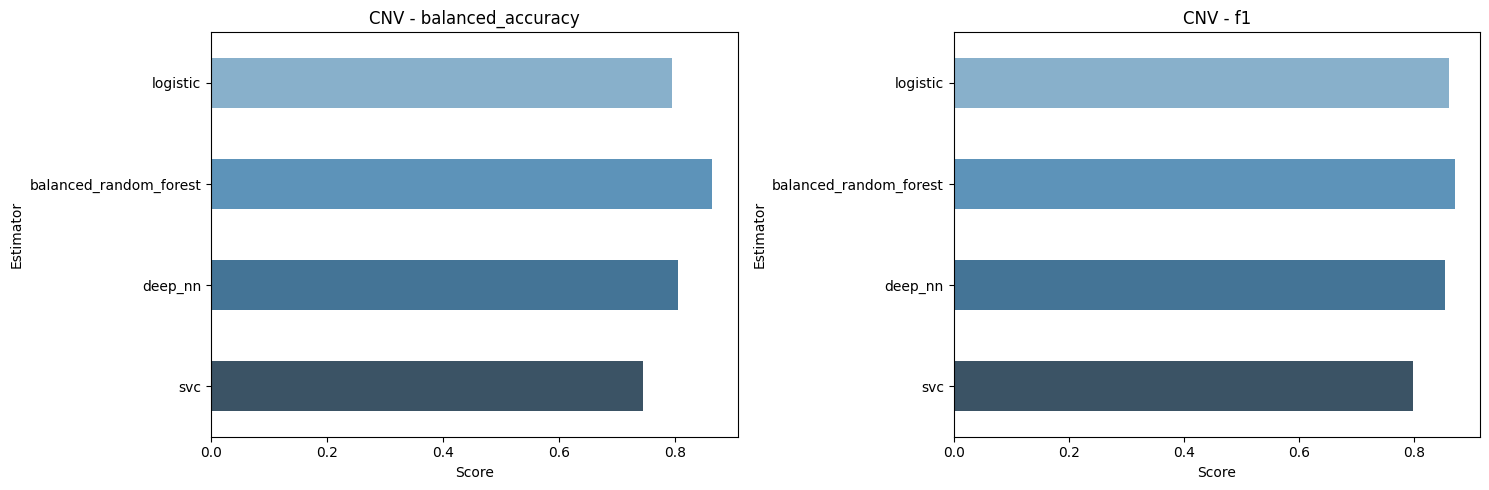

In [25]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

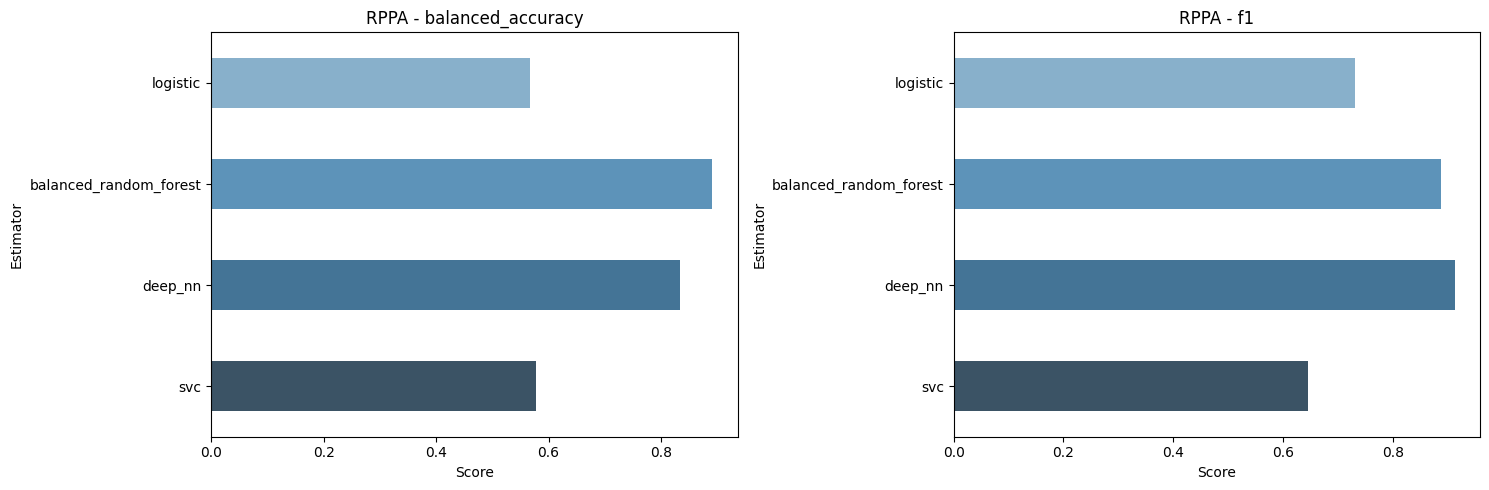

In [26]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

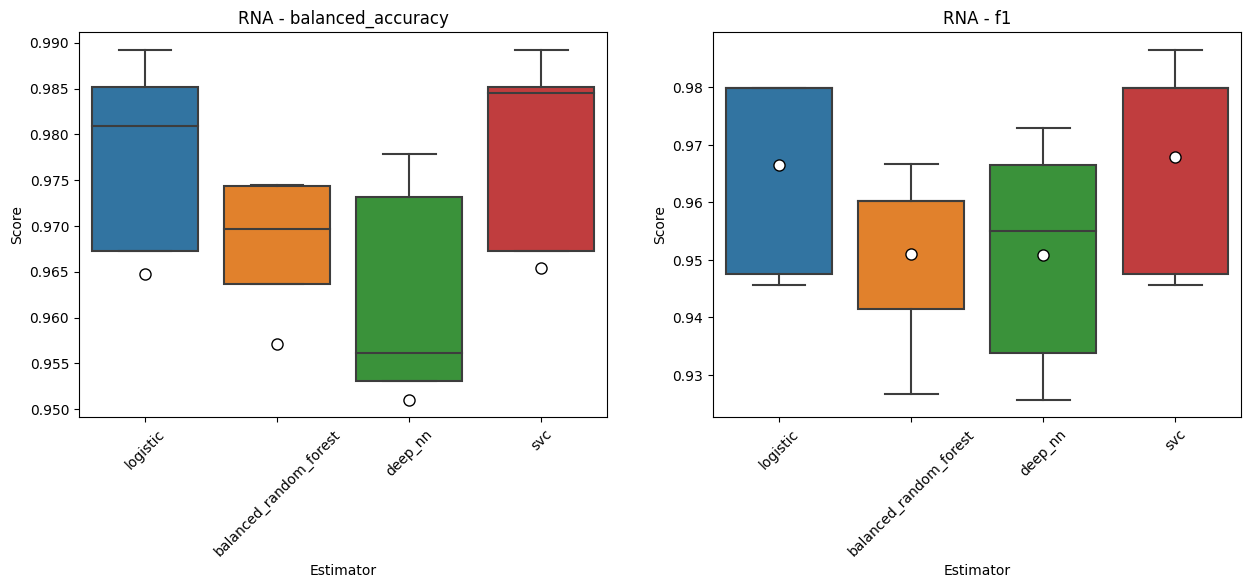

In [27]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

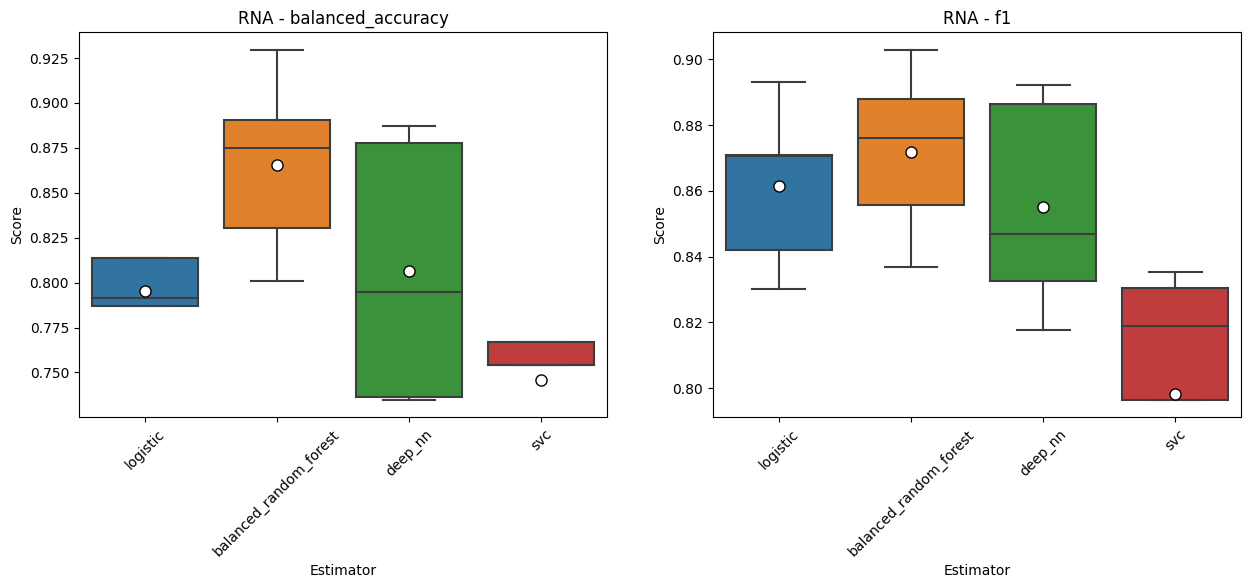

In [28]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

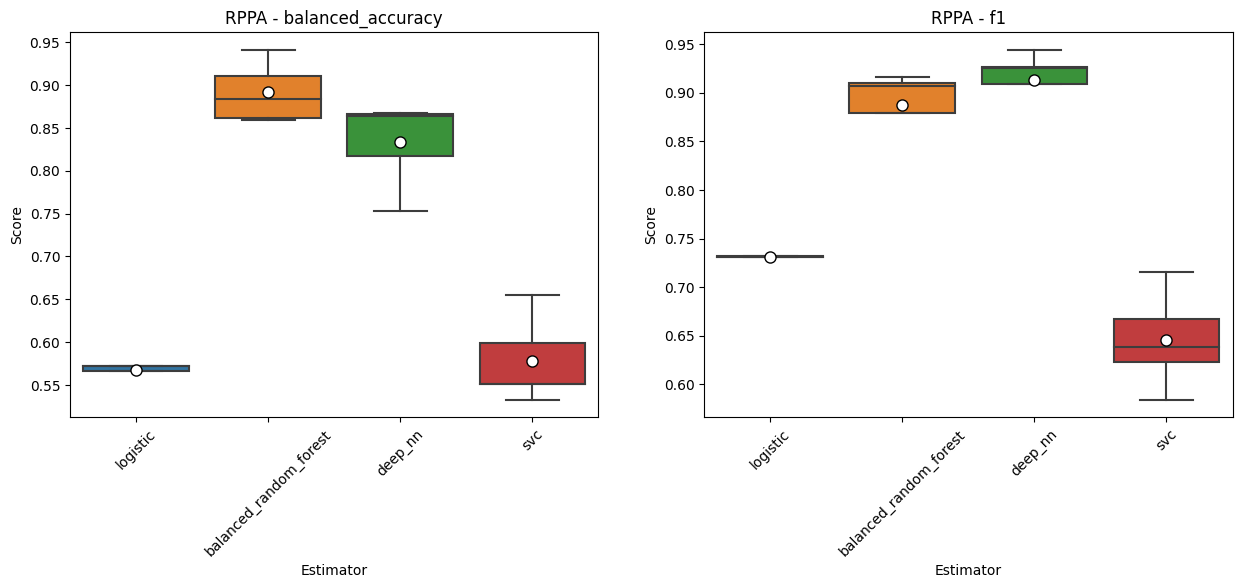

In [29]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [30]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [31]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [32]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed 

            accuracy balanced_accuracy               f1    recall (KICH)  \
rna  0.968 +/- 0.018   0.960 +/- 0.037  0.968 +/- 0.018  0.938 +/- 0.090   

       recall (KIRC)    recall (KIRP)  
rna  0.970 +/- 0.018  0.972 +/- 0.018  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

            accuracy balanced_accuracy               f1    recall (KICH)  \
cnv  0.893 +/- 0.029   0.851 +/- 0.060  0.892 +/- 0.030  0.781 +/- 0.147   

       recall (KIRC)    recall (KIRP)  
cnv  0.932 +/- 0.023  0.841 +/- 0.056  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

             accuracy balanced_accuracy               f1    recall (KICH)  \
rppa  0.936 +/- 0.026   0.883 +/- 0.051  0.934 +/- 0.028  0.781 +/- 0.099   

        recall (KIRC)    recall (KIRP)  
rppa  0.977 +/- 0.008  0.891 +/- 0.064  


In [33]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


In [84]:
modality_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072


In [34]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['cnv'].append(scores['cnv'])
all_scores['rppa'].append(scores['rppa'])

## Scoring

In [35]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [36]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.015,0.957 +/- 0.027,0.951 +/- 0.015,0.969 +/- 0.062,0.945 +/- 0.021,0.958 +/- 0.023
deep_nn,0.950 +/- 0.018,0.951 +/- 0.030,0.951 +/- 0.018,0.954 +/- 0.062,0.951 +/- 0.025,0.948 +/- 0.041
svc,0.968 +/- 0.018,0.965 +/- 0.033,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.796 +/- 0.041,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
balanced_random_forest,0.867 +/- 0.025,0.865 +/- 0.045,0.872 +/- 0.023,0.859 +/- 0.112,0.868 +/- 0.027,0.869 +/- 0.031
deep_nn,0.856 +/- 0.028,0.806 +/- 0.066,0.855 +/- 0.029,0.715 +/- 0.169,0.900 +/- 0.041,0.803 +/- 0.081
svc,0.796 +/- 0.048,0.746 +/- 0.054,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.568 +/- 0.018,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
balanced_random_forest,0.882 +/- 0.038,0.891 +/- 0.031,0.888 +/- 0.033,0.921 +/- 0.072,0.880 +/- 0.045,0.873 +/- 0.047
deep_nn,0.915 +/- 0.027,0.833 +/- 0.045,0.913 +/- 0.029,0.653 +/- 0.072,0.966 +/- 0.013,0.882 +/- 0.071
svc,0.631 +/- 0.047,0.578 +/- 0.044,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


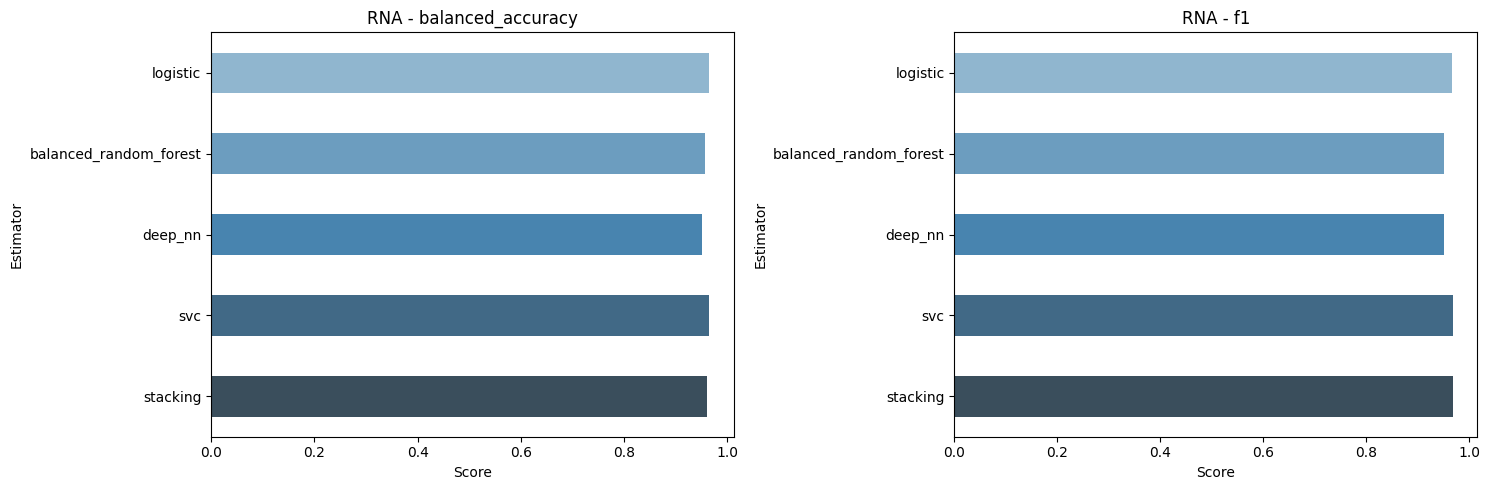

In [37]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

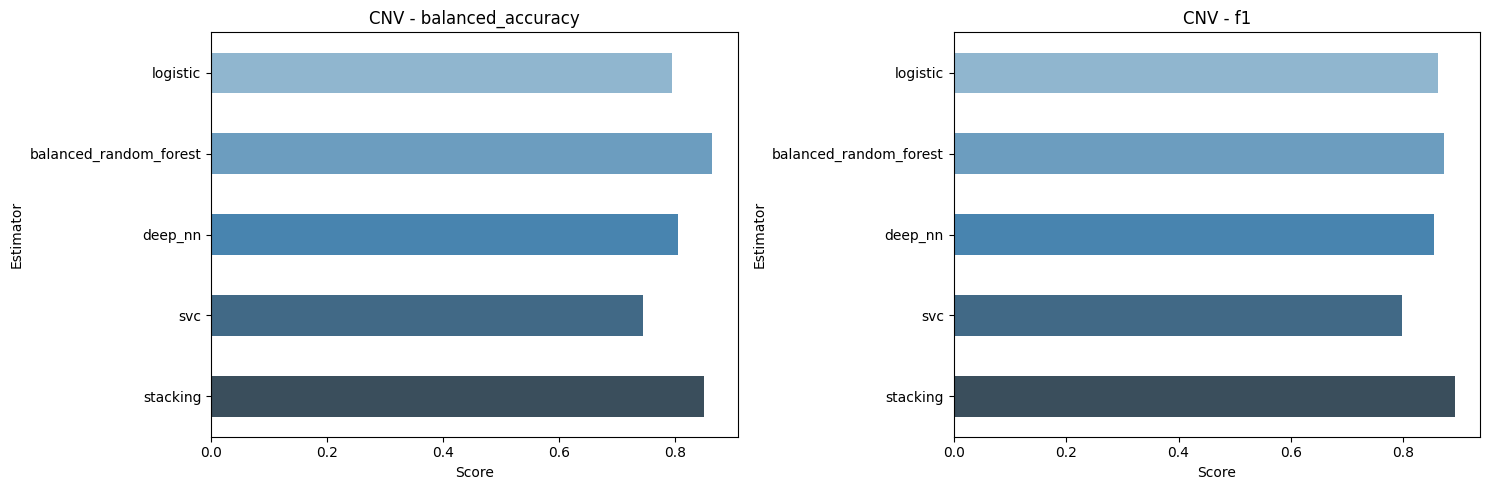

In [38]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

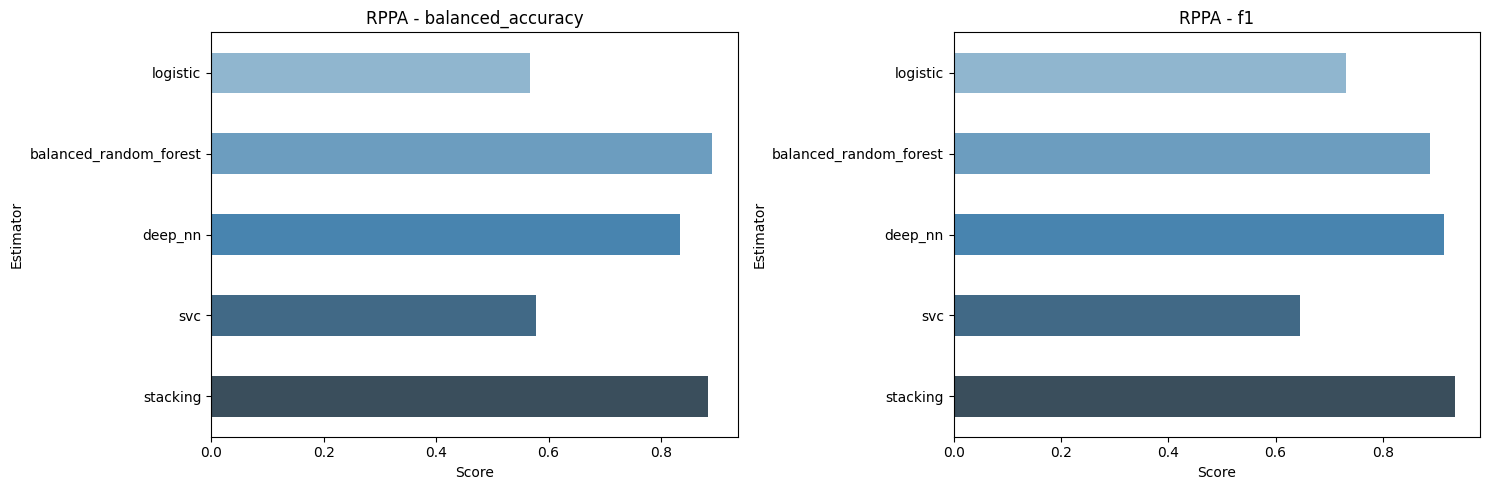

In [39]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

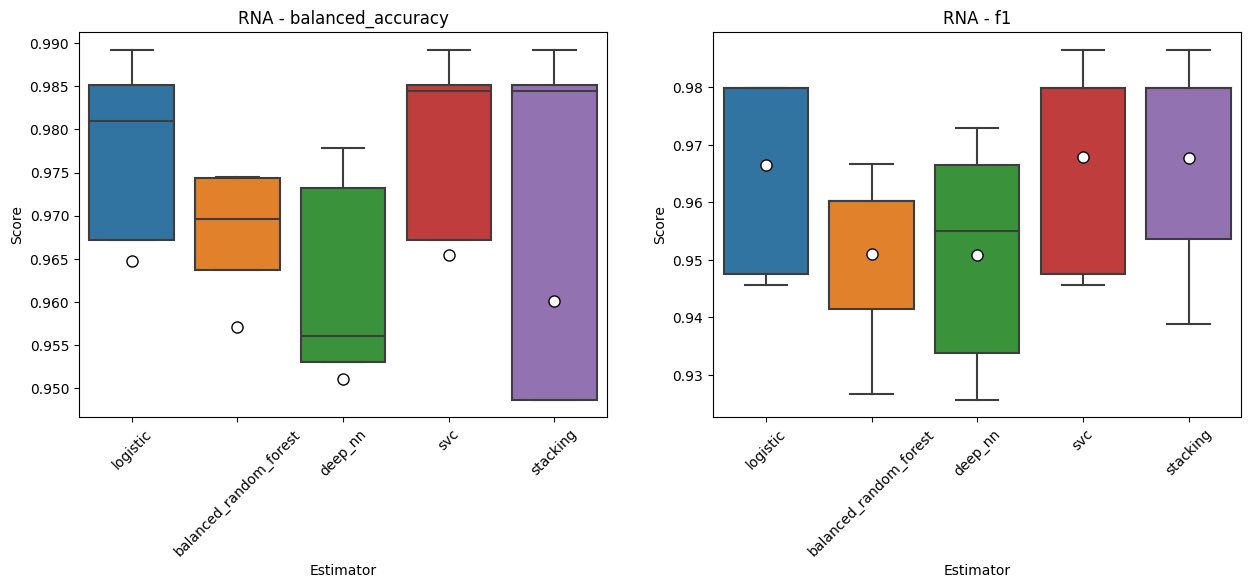

In [44]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

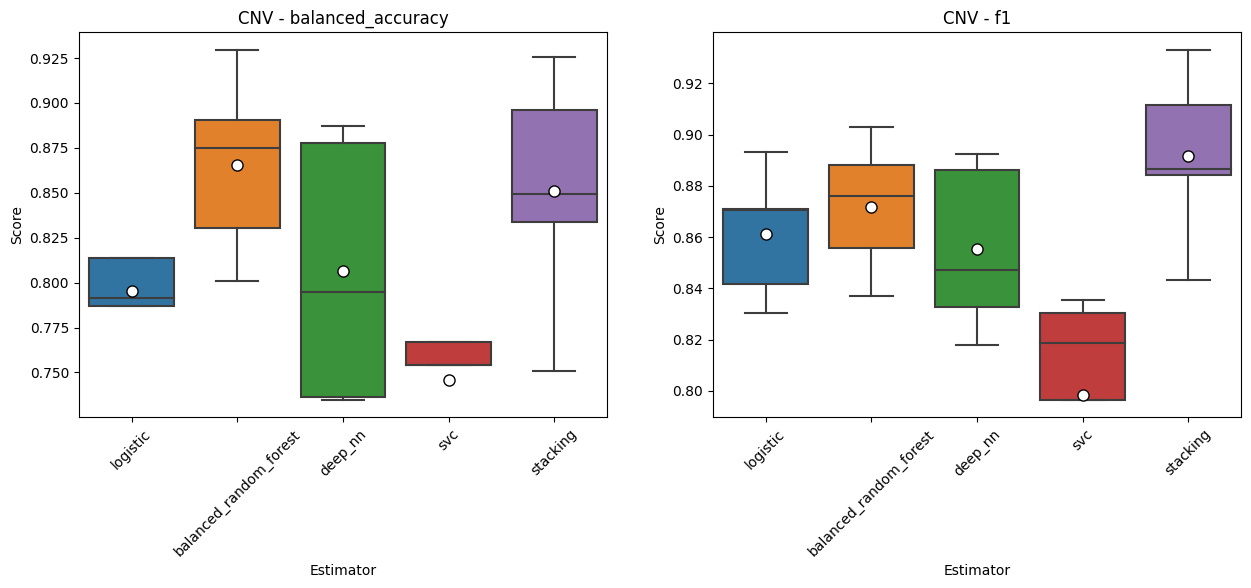

In [41]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

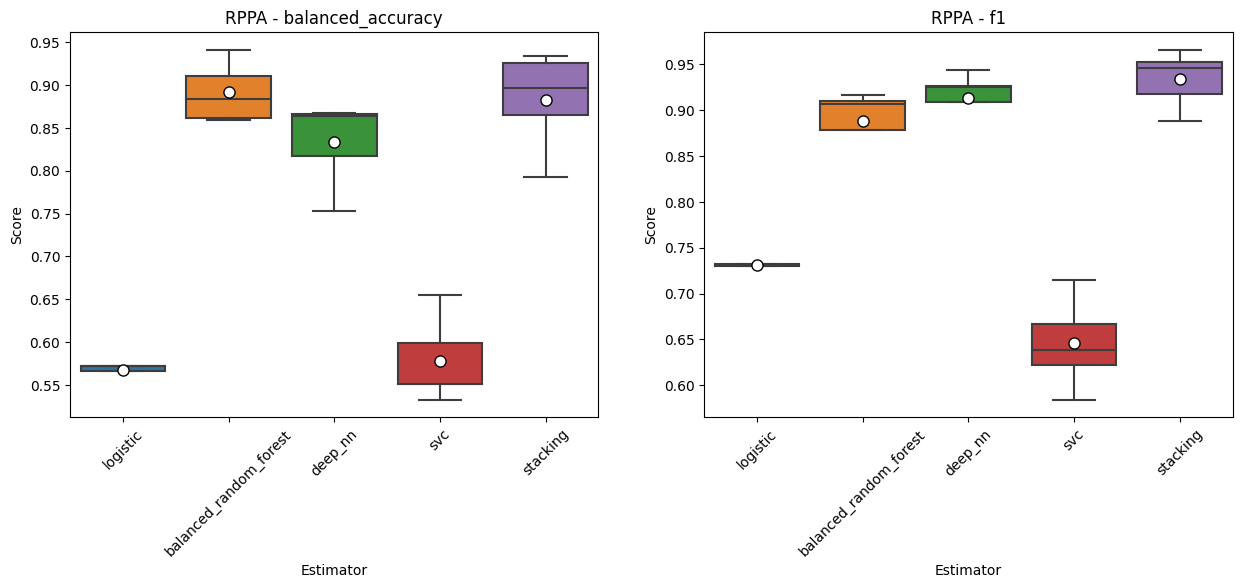

In [42]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

# Multi Omics Integration Ensemble

In [45]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method ='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed 

In [46]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['cnv'].argmax(axis=1),
    'rppa': preds['rppa'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_KICH', 'rna_KIRC', 'rna_KIRP']), pd.DataFrame(preds['cnv'], columns=['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']), pd.DataFrame(preds['rppa'], columns=['rppa_KICH', 'rppa_KIRC', 'rppa_KIRP'])], axis=1)

In [47]:
preds_class_df

,rna,cnv,rppa
0,0,0,0
1,0,0,0
2,0,2,0
3,0,0,0
4,0,0,1
...,...,...,...
740,2,2,2
741,2,2,2
742,2,1,2
743,2,2,2


In [48]:
preds_proba_df

,rna_KICH,rna_KIRC,rna_KIRP,cnv_KICH,cnv_KIRC,cnv_KIRP,rppa_KICH,rppa_KIRC,rppa_KIRP
0,0.915607,0.045604,0.038789,0.898000,0.076016,0.025984,0.664656,0.089507,0.245838
1,0.862500,0.129541,0.007958,0.909660,0.066129,0.024211,0.927931,0.022498,0.049571
2,0.937118,0.030343,0.032540,0.089807,0.317458,0.592735,0.972242,0.021291,0.006467
3,0.849237,0.139902,0.010861,0.602241,0.310769,0.086990,0.895499,0.060093,0.044409
4,0.935229,0.026760,0.038010,0.955289,0.034666,0.010045,0.283692,0.399620,0.316688
...,...,...,...,...,...,...,...,...,...
740,0.004060,0.020598,0.975342,0.048437,0.222579,0.728984,0.007751,0.012599,0.979650
741,0.003511,0.014863,0.981625,0.007451,0.031505,0.961043,0.010171,0.020882,0.968948
742,0.008283,0.026506,0.965211,0.014118,0.946792,0.039090,0.283740,0.030794,0.685466
743,0.006007,0.021183,0.972810,0.008341,0.027612,0.964047,0.004768,0.004171,0.991062


### With Voting:

In [108]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Find the majority class for each sample
majority_class = pred_df.mode(axis=1)[0]

# Calculate the scores
accuracy = accuracy_score(y, majority_class)
f1 = f1_score(y, majority_class, average='weighted')
recall = recall_score(y, majority_class, average=None)

scores_df = pd.DataFrame({'accuracy': [accuracy], 'f1': [f1], 'recall (KICH)': [recall[0]], 'recall (KIRC)': [recall[1]], 'recall (KIRP)': [recall[2]]})

# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, scores_df.rename(index={0: 'majority_class'})])

integration_voting_metrics


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072
majority_class,0.969128,0.969151,0.936508,0.976546,0.962441


### With Stacking:

In [50]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s


[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


In [51]:
integration_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
Integration Model,0.961 +/- 0.026,0.961 +/- 0.027,0.892 +/- 0.115,0.979 +/- 0.018,0.944 +/- 0.036


In [103]:
names = ['cnv', 'rna', 'rppa', 'integration']
integration = []
integration.append(scores['cnv'])
integration.append(scores['rna'])
integration.append(scores['rppa'])
integration.append(integration_scores)

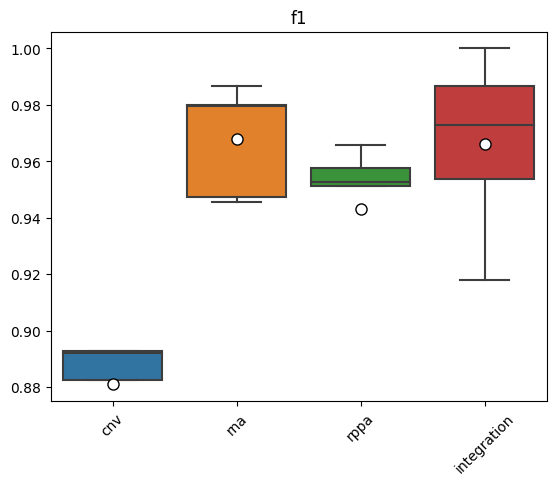

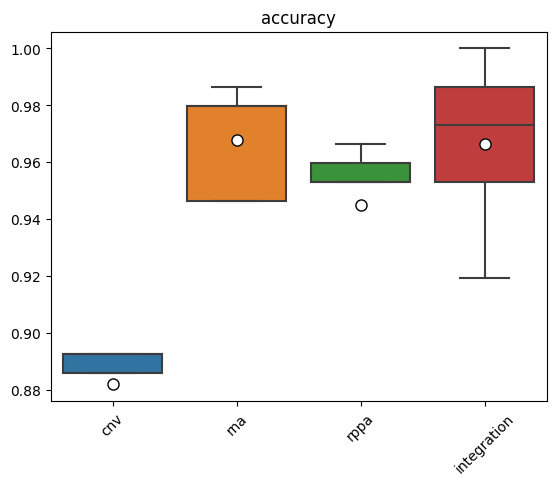

In [104]:
plot_scores(names, integration)

In [52]:
rna_cnv_rppa_scores, rna_cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
cnv_rppa_scores, cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_rppa_scores, rna_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='rna + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_cnv_scores, rna_cnv_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']], y, name='rna + cnv', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [53]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_cnv_rppa_df, cnv_rppa_df, rna_rppa_df, rna_cnv_df])

In [54]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064
rna + cnv + rppa,0.976 +/- 0.021,0.961 +/- 0.036,0.976 +/- 0.021,0.923 +/- 0.084,0.983 +/- 0.017,0.976 +/- 0.015
cnv + rppa,0.966 +/- 0.014,0.934 +/- 0.038,0.966 +/- 0.015,0.860 +/- 0.101,0.985 +/- 0.011,0.958 +/- 0.023
rna + rppa,0.976 +/- 0.016,0.961 +/- 0.034,0.976 +/- 0.016,0.923 +/- 0.084,0.983 +/- 0.014,0.977 +/- 0.021
rna + cnv,0.968 +/- 0.018,0.959 +/- 0.036,0.968 +/- 0.018,0.938 +/- 0.090,0.972 +/- 0.020,0.967 +/- 0.024


In [58]:
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']
integration = []
integration.append(scores['rna'])
integration.append(scores['cnv'])
integration.append(scores['rppa'])
integration.append(rna_cnv_rppa_scores)
integration.append(cnv_rppa_scores)
integration.append(rna_rppa_scores)
integration.append(rna_cnv_scores)

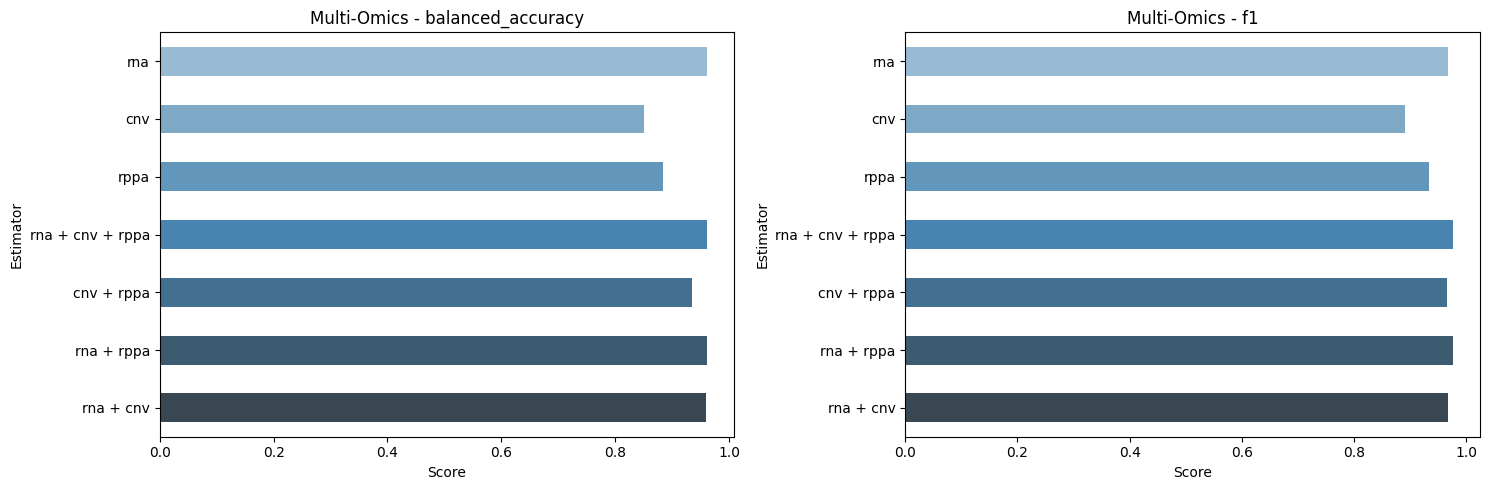

In [59]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

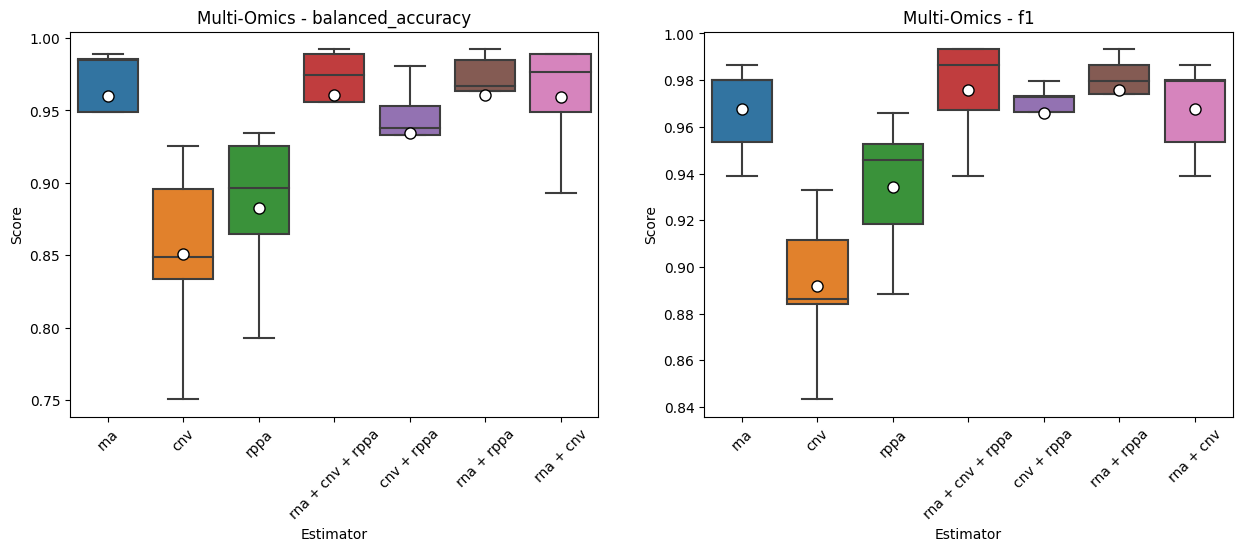

In [60]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])